In [57]:
# Data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio

# Machine learning
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from rasterio.transform import from_origin

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib import colors

# System utilities
import os
import joblib

In [58]:
def load_cvr_items(cvr):
    results_dir = f'results/optimization/{cvr}'

    study = joblib.load(os.path.join(results_dir, "study.pkl"))
    trial = study.best_trial

    params = trial.params

    params.update({
        'objective': 'tweedie',
        'metric': 'l1',
        'random_state': 42,
        'n_jobs': 1,
        'verbosity': -1
    })
    #lidar-based target data
    lidar_path = 'data/raster/lidar_products/2019_lidar_cover.tif'

    #rap data (predictor)
    rap_path = 'data/raster/rap/woody_cover_2019.tif'

    #static terrain predictors
    dem_path = 'data/raster/ned/ned.tif'
    slope_path = 'data/raster/terrain/slope.tif'
    hli_path = 'data/raster/terrain/hli.tif'
    tpi_path = f'data/raster/terrain/tpi_{params["tpi_ngb"]}.tif'
    twi_path = 'data/raster/terrain/twi.tif'
    covertype_path = 'data/raster/terrain/covertype.tif'

    #print(tpi_path)
    #train sample locations
    train_points_path = 'data/vector/train_points_with_folds.geojson'

    gpd_train_points = gpd.read_file(train_points_path)
    gpd_train_points = gpd_train_points[gpd_train_points['covertype'] == cvr]
    # Read raster data for all points first
    with rasterio.open(lidar_path) as src:
        lidar = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

    with rasterio.open(rap_path) as src:
        rap = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

    with rasterio.open(dem_path) as src:
        dem = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

    with rasterio.open(slope_path) as src:
        slope = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

    with rasterio.open(hli_path) as src:
        hli = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

    with rasterio.open(tpi_path) as src:
        tpi = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

    with rasterio.open(twi_path) as src:
        twi = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

    with rasterio.open(covertype_path) as src:
        covertype = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

    Y = np.array(lidar)

    # Create feature dataframe for all points
    X = pd.DataFrame({
        'rap': rap,
        'dem': dem, 
        'slope': slope,
        'hli': hli,
        'tpi': tpi,
        'twi': twi,
    })

    return X, Y, gpd_train_points.reset_index(drop=True), params

In [59]:
def process_fold(fold, params, X, Y, gpd_train_points):  

    train_mask = (gpd_train_points['fold'] != fold)
    test_mask = (gpd_train_points['fold'] == fold)

    #extract idx col, apply test mask, and get values
    x_coords = gpd_train_points.loc[test_mask, 'geometry'].apply(lambda geom: (geom.x)).values
    y_coords = gpd_train_points.loc[test_mask, 'geometry'].apply(lambda geom: (geom.y)).values

    # Add tpi to the feature dataframe
    X_fold = X.copy()

    X_train = X_fold[train_mask]
    X_test = X_fold[test_mask]
    y_train = np.array(Y)[train_mask]
    y_test = np.array(Y)[test_mask]

    # Create the LightGBM model
    lgb_model = lgb.LGBMRegressor(**params)

    lgb_model.fit(X_train, y_train,
                      eval_set=[(X_test, y_test)],
                      eval_metric=params['metric'])
    score = lgb_model.evals_result_['valid_0'][params['metric']][-1]
    y_pred = lgb_model.predict(X_test)
    return score, y_test, y_pred, x_coords, y_coords, X_test['rap']

n_folds = 5

results = []
scores = []

for cvr in [0.0, 1.0, 2.0]:
    X, Y, gpd_train_points, params = load_cvr_items(cvr)
    fold_results = joblib.Parallel(n_jobs=n_folds)(
        joblib.delayed(process_fold)(fold, params, X, Y, gpd_train_points)
        for fold in range(n_folds)
    )
    scores.append(np.mean([score for score, y_test, y_pred, x_coord, y_coord, rap in fold_results]))

    for fold, (score, y_test, y_pred, x_coord, y_coord, rap) in enumerate(fold_results):
        results.append(pd.DataFrame({
            'cvr': cvr,
            'fold': fold,
            'score': score,
            'y_test': y_test,
            'y_pred': y_pred,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'rap': rap
        }))

test_df = pd.concat(results, ignore_index=True)
print(scores)

[3.082293960434085, 7.566564158462711, 15.872265280818075]


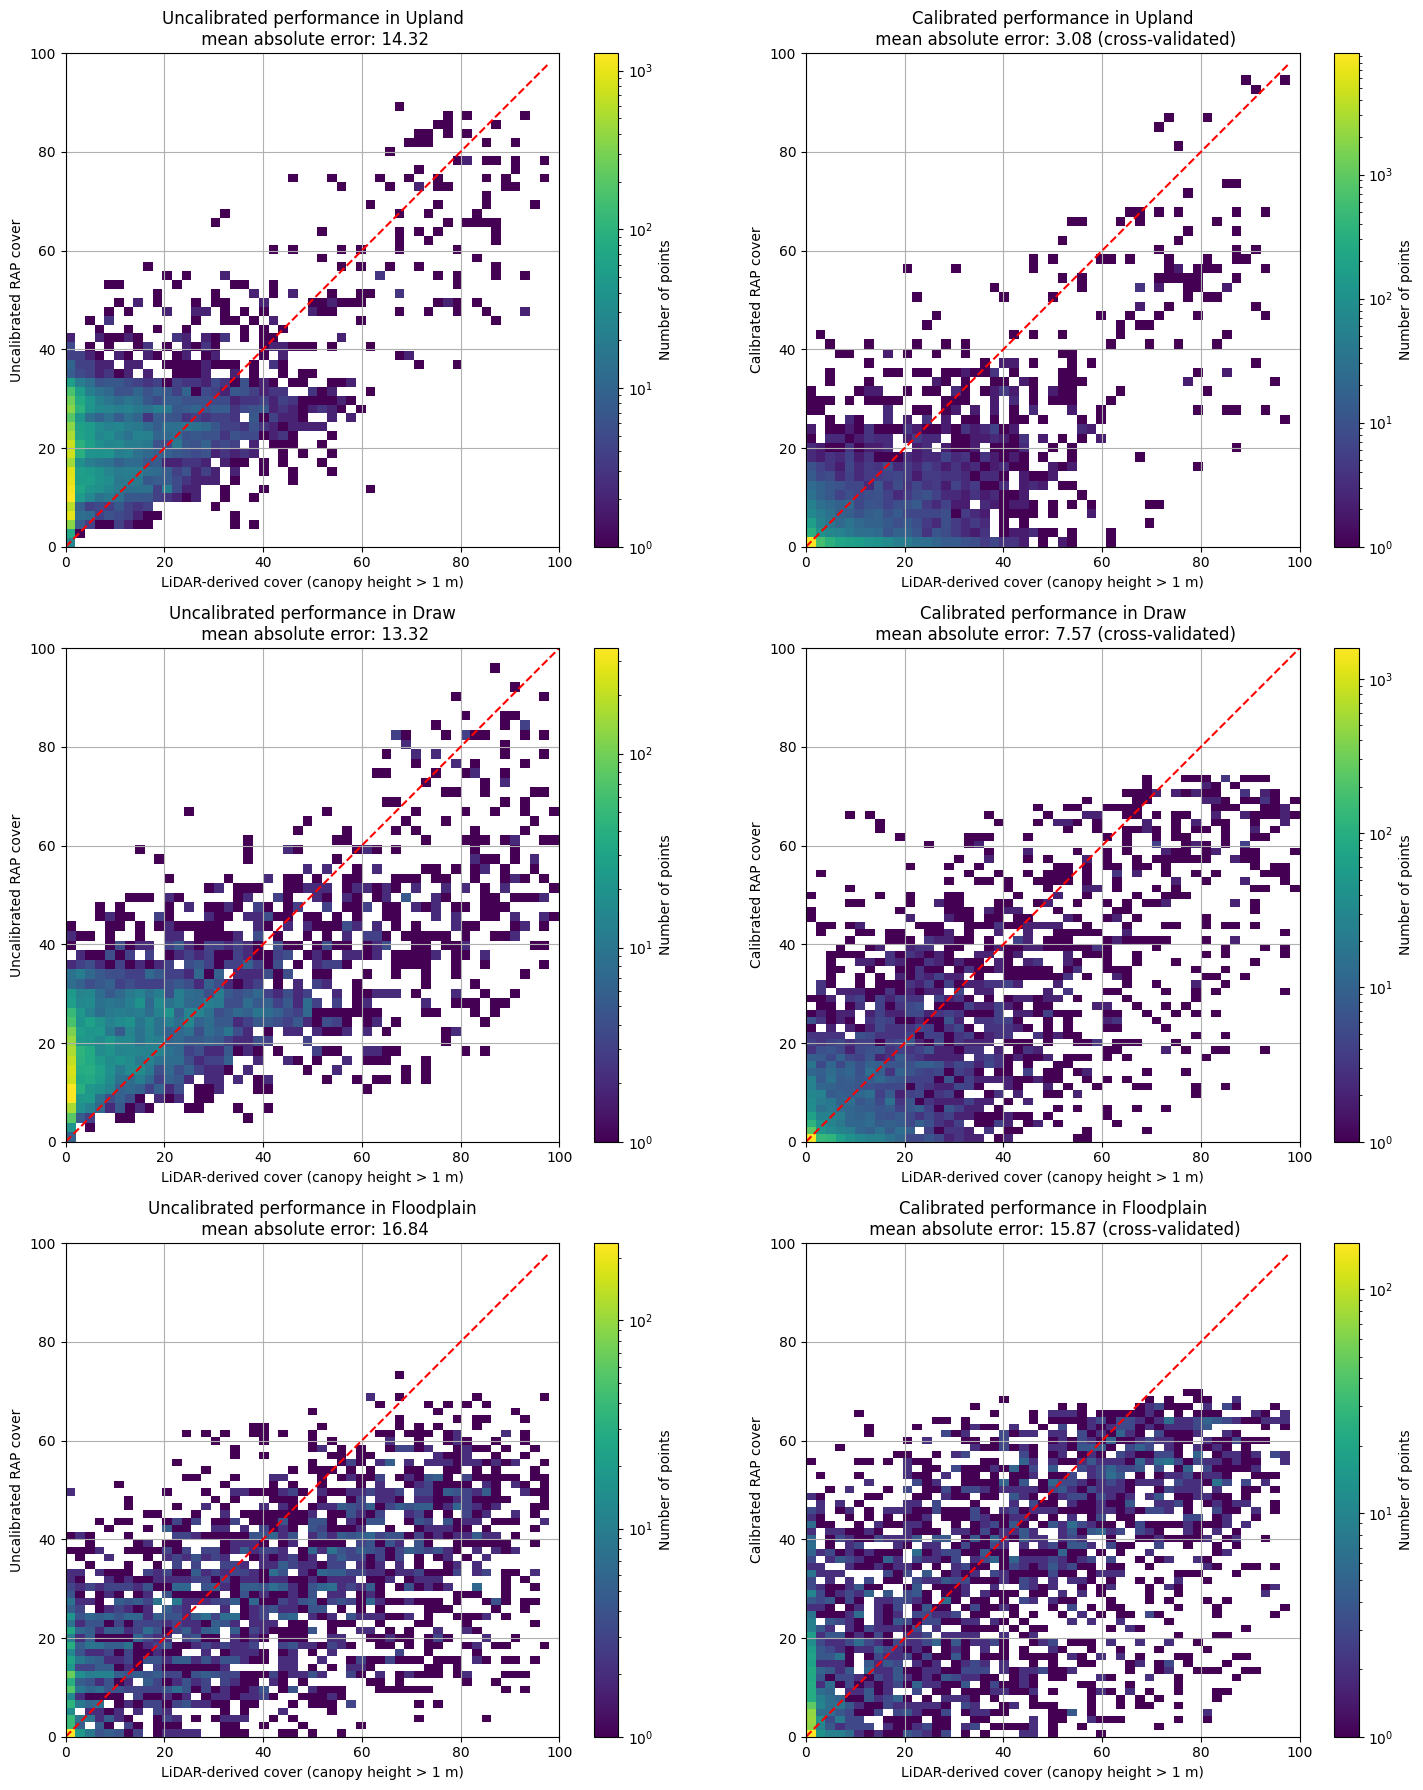

In [60]:
# Create the figure and axes for the two subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
cover_types = [0, 1, 2]
cover_type_names = ['Upland', 'Draw', 'Floodplain']

for i, cover_type in enumerate(cover_types):
    df_subset = test_df[test_df['cvr'] == cover_type]
    focal_name = cover_type_names[i]

    h = axes[i, 0].hist2d(df_subset['y_test'], df_subset['rap'], bins=50, cmap='viridis', norm=colors.LogNorm())
    cbar = plt.colorbar(h[3], ax=axes[i, 0])
    cbar.ax.set_ylabel('Number of points')
    score_rap_lidar = mean_absolute_error(df_subset['y_test'], df_subset['rap'])
    axes[i, 0].set_xlabel(f'LiDAR-derived cover (canopy height > 1 m)')
    axes[i, 0].set_ylabel('Uncalibrated RAP cover')
    axes[i, 0].set_title(f'Uncalibrated performance in {focal_name}\n mean absolute error: {score_rap_lidar:.2f}')
    axes[i, 0].grid(True)
    min_val = min(min(df_subset['y_test']), min(df_subset['rap']))
    max_val = max(max(df_subset['y_test']), max(df_subset['rap']))
    axes[i, 0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    axes[i, 0].set_aspect('equal', adjustable='box')

    # Set axis limits to 100
    axes[i, 0].set_xlim(0, 100)
    axes[i, 0].set_ylim(0, 100)


    # Create the scatter plot with reduced point size and increased transparency
    h = axes[i, 1].hist2d(df_subset['y_test'], df_subset['y_pred'], bins=50, cmap='viridis', norm=colors.LogNorm())
    cbar = plt.colorbar(h[3], ax=axes[i, 1])
    cbar.ax.set_ylabel('Number of points')

    # Plot the 1 to 1 line
    axes[i, 1].plot([min(df_subset['y_test']), max(df_subset['y_test'])], [min(df_subset['y_test']), max(df_subset['y_test'])], 'r--')

    # Set the aspect ratio to be equal
    axes[i, 1].set_aspect('equal', adjustable='box')

    # Add labels and title
    axes[i, 1].set_xlabel('LiDAR-derived cover (canopy height > 1 m)')
    axes[i, 1].set_ylabel('Calibrated RAP cover')
    axes[i, 1].set_title(f'Calibrated performance in {focal_name}\n mean absolute error: {scores[i]:.2f} (cross-validated)')

    # Set axis limits to 100
    axes[i, 1].set_xlim(0, 100)
    axes[i, 1].set_ylim(0, 100)
    axes[i, 1].grid(True)


# Show the plot
plt.tight_layout()
plt.show()

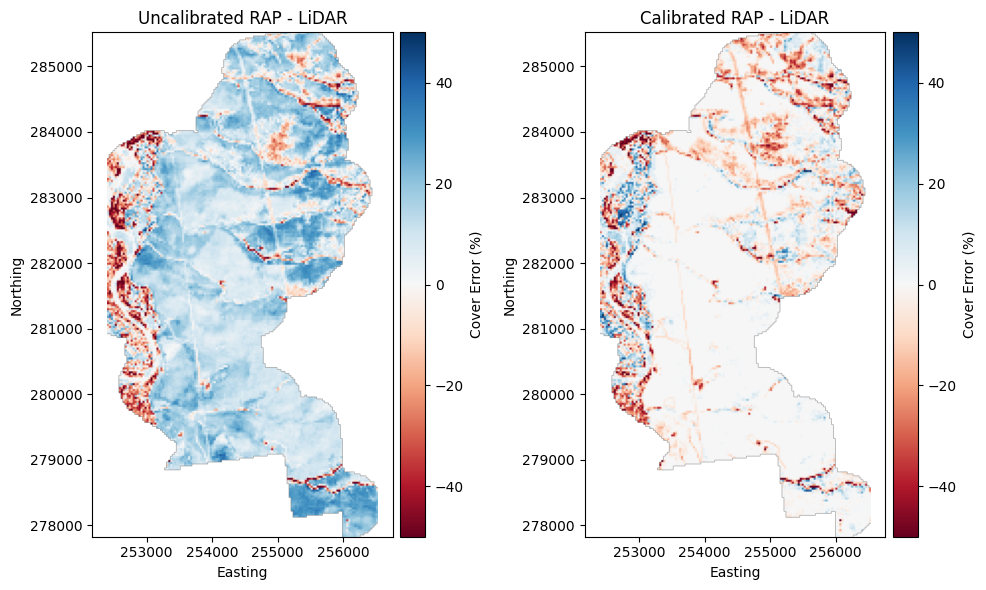

In [66]:
# Determine the bounds of the raster
min_easting, max_easting = min(test_df['x_coord']), max(test_df['x_coord'])
min_northing, max_northing = min(test_df['y_coord']), max(test_df['y_coord'])

# Define the resolution of the raster
resolution = 30  # Adjust as needed

# Calculate the number of rows and columns
width = int((max_easting - min_easting) / resolution)
height = int((max_northing - min_northing) / resolution)

# Create empty rasters with NaN values
raster_rap_error = np.full((height, width), np.nan)
raster_pred_error = np.full((height, width), np.nan)

# Rasterize the differences
for i, (x, y) in enumerate(zip(test_df['x_coord'], test_df['y_coord'])): 
    col = int((x - min_easting) / resolution)
    row = int((max_northing - y) / resolution)
    if 0 <= row < height and 0 <= col < width:
        # Access elements using the flattened index
        raster_rap_error[row, col] = test_df['rap'].iloc[i] - test_df['y_test'].iloc[i]
        raster_pred_error[row, col] = test_df['y_pred'].iloc[i] - test_df['y_test'].iloc[i]


# Create a binary map for the lowest error
raster_lowest_error = np.full((height, width), np.nan)
for i, (x, y) in enumerate(zip(test_df['x_coord'], test_df['y_coord'])): 
    col = int((x - min_easting) / resolution)
    row = int((max_northing - y) / resolution)
    if 0 <= row < height and 0 <= col < width:
        # Determine which method has the lowest absolute error
        if abs(raster_rap_error[row, col]) < abs(raster_pred_error[row, col]):
            raster_lowest_error[row, col] = 0  # 0 represents uncalibrated RAP
        else:
            raster_lowest_error[row, col] = 1  # 1 represents calibrated RAP

# Create masked arrays to handle NaN values for transparency
masked_raster_rap_error = np.ma.masked_invalid(raster_rap_error)
masked_raster_pred_error = np.ma.masked_invalid(raster_pred_error)
masked_raster_lowest_error = np.ma.masked_invalid(raster_lowest_error)

# Plot the rasters
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot the first raster (rap_test - y_test)
im1 = axes[0].imshow(masked_raster_rap_error, extent=(min_easting, max_easting, min_northing, max_northing), cmap='RdBu', vmin=-50, vmax=50)
axes[0].set_title('Uncalibrated RAP - LiDAR')
cbar1 = plt.colorbar(im1, ax=axes[0], orientation='vertical', pad=0.02)
cbar1.set_label('Cover Error (%)')
axes[0].set_xlabel('Easting')
axes[0].set_ylabel('Northing')

# Plot the second raster (y_pred - y_test)
im2 = axes[1].imshow(masked_raster_pred_error, extent=(min_easting, max_easting, min_northing, max_northing), cmap='RdBu', vmin=-50, vmax=50)
axes[1].set_title('Calibrated RAP - LiDAR')
cbar2 = plt.colorbar(im2, ax=axes[1], orientation='vertical', pad=0.02)
cbar2.set_label('Cover Error (%)')
axes[1].set_xlabel('Easting')
axes[1].set_ylabel('Northing')

plt.subplots_adjust(wspace=0.4, hspace=0.1)  # Adjust wspace (width space) and hspace (height space)

# Set the same y-limits for all axes
axes[0].set_ylim(min_northing, max_northing)
axes[1].set_ylim(min_northing, max_northing)

# Set aspect ratio for all subplots to be equal
for ax in axes:
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()


In [62]:
# Add tpi to the feature dataframe
X_production = X.copy()
Y_production = np.array(Y)

# Create the LightGBM model
lgb_production_mod = lgb.LGBMRegressor(**params)

lgb_production_mod.fit(X_production, Y_production)
y_pred_production = lgb_production_mod.predict(X_production)

In [63]:
y_pred_production_cvr = []
coords = []
model_dir = 'results/models/production'
os.makedirs(model_dir, exist_ok=True)

for cvr in [0.0, 1.0, 2.0]:
    X, Y, gpd_train_points, params = load_cvr_items(cvr)
    
    lgb_production_mod = lgb.LGBMRegressor(**params)
    lgb_production_mod.fit(X, Y)
    joblib.dump(lgb_production_mod, os.path.join(model_dir, f'lgb_production_mod_{cvr}.pkl'))
    
    y_pred_production_cvr.append(lgb_production_mod.predict(X))
    coords.append(gpd_train_points.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_3842/1889921979.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([0, 10, 20, 30, 40, '50+'])


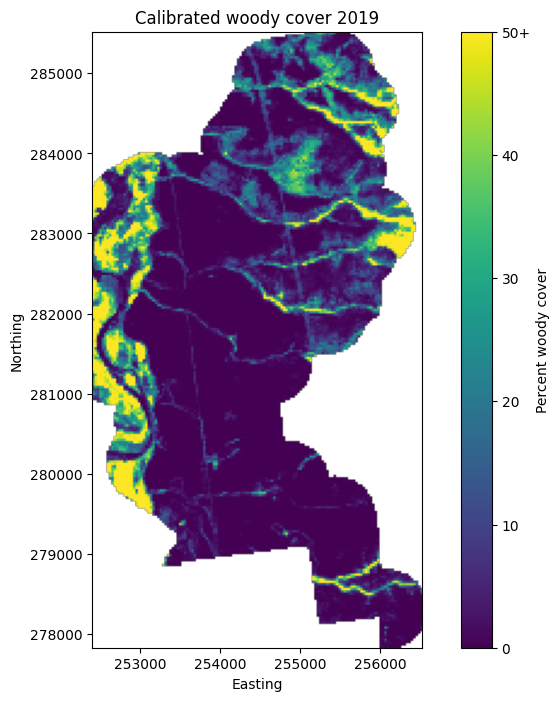

In [64]:
# Extract coordinates from the GeoDataFrame
coords = [coord for sublist in coords for coord in sublist]
y_pred_production = np.concatenate(y_pred_production_cvr)

x_coords, y_coords = zip(*coords)
# Determine the bounds of the raster
min_x, max_x = min(x_coords), max(x_coords)
min_y, max_y = min(y_coords), max(y_coords)

# Define the resolution of the raster
resolution = 30  # Adjust as needed

# Calculate the number of rows and columns
width = int((max_x - min_x) / resolution)
height = int((max_y - min_y) / resolution)

# Create a transform for the raster
transform = from_origin(min_x, max_y, resolution, resolution)

# Create an empty raster with NaN values
raster = np.full((height, width), np.nan)

# Rasterize the predictions
for i, (x, y) in enumerate(coords):
    col = int((x - min_x) / resolution)
    row = int((max_y - y) / resolution)
    if 0 <= row < height and 0 <= col < width:
        raster[row, col] = y_pred_production[i]

# Create a masked array to handle NaN values for transparency
masked_raster = np.ma.masked_invalid(raster)

# Plot the raster
plt.figure(figsize=(10, 8))
im = plt.imshow(masked_raster, extent=(min_x, max_x, min_y, max_y), cmap='viridis', vmin=0, vmax=50)
cbar = plt.colorbar(im, label='Percent woody cover')
cbar.ax.set_yticklabels([0, 10, 20, 30, 40, '50+'])
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Calibrated woody cover 2019')
plt.show()